### 1. Importación de Librerías

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objs as go

### 2. Cargar el dataset

In [ ]:
df = pd.read_excel("..\prediccion_reforestacion\data\data_monitoreo_contaminantes.xlsx")

### 3. Preprocesamiento de datos

In [ ]:
# Convertir columna de fecha a datetime
df['FECHA'] = pd.to_datetime(df['FECHA'])

# Extraer año y mes
df['YEAR'] = df['FECHA'].dt.year
df['MONTH'] = df['FECHA'].dt.month

In [ ]:
# Limpiar columnas numéricas
numeric_cols = ['PM10', 'PM2_5']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [ ]:
# Rellenar datos vacíos con la media del trimestre
def fill_missing_with_quarterly_mean(group):
    return group.fillna(group.mean())

df[numeric_cols] = df.groupby([df['YEAR'], (df['MONTH']-1)//3])[numeric_cols].transform(fill_missing_with_quarterly_mean)

In [ ]:
# Estadísticas descriptivas
df[['DISTRITO', 'PM10', 'PM2_5']].describe()

,PM10,PM2_5
count,577794.000000,577794.000000
mean,60.895577,24.047421
std,38.453101,12.944777
min,2.310000,1.730000
25%,38.250000,16.100000
50%,54.889553,22.038419
75%,72.376363,28.610110
max,974.000000,720.700000


In [ ]:
#Muestra de la data
df[['DISTRITO', 'PM10', 'PM2_5']].sample(10)

,DISTRITO,PM10,PM2_5
154142,CARABAYLLO,102.000000,47.730000
123401,CARABAYLLO,51.860719,29.180886
449056,SAN_MARTIN_DE_PORRES,53.411421,19.457680
371478,SAN_JUAN_DE_LURIGANCHO,50.470000,29.180886
564384,VILLA_MARIA_DEL_TRIUNFO,70.140000,28.860000
182527,SANTA_ANITA,63.460000,29.700000
431639,SAN_MARTIN_DE_PORRES,18.830000,16.200000
562553,VILLA_MARIA_DEL_TRIUNFO,72.900000,39.180000
484615,SAN_MARTIN_DE_PORRES,23.530000,15.710000
217930,SANTA_ANITA,54.400000,15.773739


### 4. Filtrado de Datos Atípicos

In [ ]:
# Filtrar datos de PM10 dentro del rango de SENAMHI (0 - 424)
df_filtrado = df[(df['PM10'] >= 0) & (df['PM10'] <= 424)]
# Filtrar datos de PM10 dentro del rango de SENAMHI (0 - 225.4)
df_filtrado = df_filtrado[(df_filtrado['PM10'] >= 0) & (df_filtrado['PM10'] <= 225.4)]

### 5. Análisis exploratorio de datos

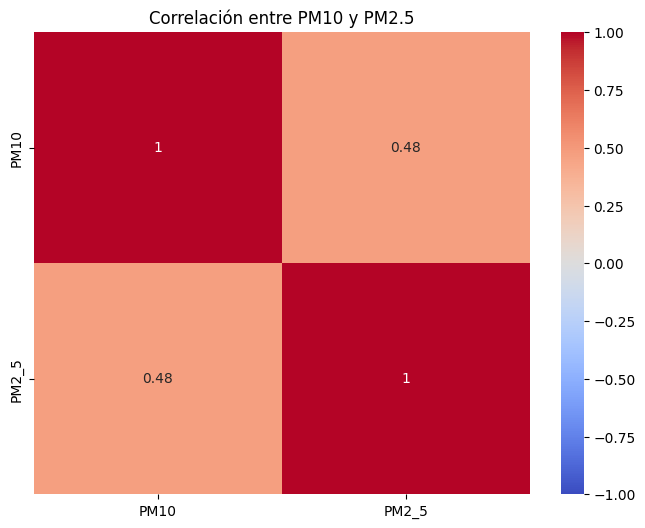

Coeficiente de correlación de Pearson: 0.4762


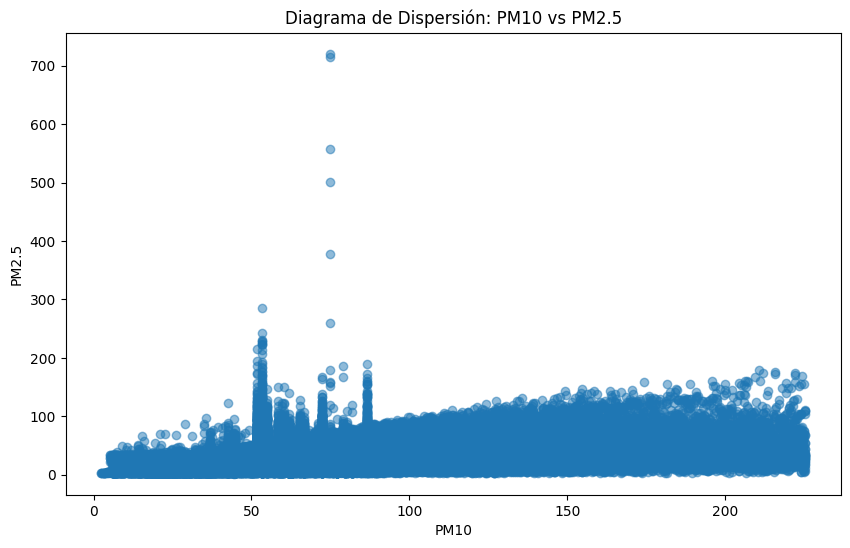

In [9]:
# Calcular correlación
correlation_matrix = df_filtrado[['PM10', 'PM2_5']].corr()

# Crear heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix, 
    annot=True,  # Mostrar valores numéricos
    cmap='coolwarm',  # Paleta de colores
    center=0,  # Centrar en 0
    vmin=-1, 
    vmax=1
)
plt.title('Correlación entre PM10 y PM2.5')
plt.show()

# Cálculo del coeficiente de correlación de Pearson
pearson_corr = df_filtrado['PM10'].corr(df_filtrado['PM2_5'])
print(f"Coeficiente de correlación de Pearson: {pearson_corr:.4f}")

# Dispersión
plt.figure(figsize=(10, 6))
plt.scatter(df_filtrado['PM10'], df_filtrado['PM2_5'], alpha=0.5)
plt.title('Diagrama de Dispersión: PM10 vs PM2.5')
plt.xlabel('PM10')
plt.ylabel('PM2.5')
plt.show()

In [10]:
# Calcular promedio de contaminantes por distrito y año
distrito_pollution = df_filtrado.groupby(['DISTRITO', 'YEAR'])['PM10'].mean().reset_index()

# Gráfico de barras con escala de color basada en concentración
fig_distrito = px.bar(
    distrito_pollution, 
    x='DISTRITO', 
    y='PM10', 
    color='PM10',  # Color basado en concentración
    color_continuous_scale='OrRd',  # Escala de color (verde a amarillo a púrpura)
    title='Niveles Promedio de Contaminación de PM10 por Distrito',
    labels={'PM10': 'Concentración'},
    animation_frame='YEAR',  # Slider de año
    animation_group='DISTRITO'
)

fig_distrito.update_layout(
    xaxis_title='Distrito',
    yaxis_title='Concentración PM10',
    xaxis = dict(tickangle = 10), # Rotar etiquetas
    margin=dict(b=150) # Aumentar margen inferior
)

fig_distrito.show()

In [11]:
# Calcular promedio de contaminantes por distrito y año
distrito_pollution = df_filtrado.groupby(['DISTRITO', 'YEAR'])['PM2_5'].mean().reset_index()

# Gráfico de barras con escala de color basada en concentración
fig_distrito = px.bar(
    distrito_pollution, 
    x='DISTRITO', 
    y='PM2_5', 
    color='PM2_5',  # Color basado en concentración
    color_continuous_scale='OrRd',  # Escala de color (verde a amarillo a púrpura)
    title='Niveles Promedio de Contaminación de PM2_5 por Distrito',
    labels={'PM2_5': 'Concentración'},
    animation_frame='YEAR',  # Slider de año
    animation_group='DISTRITO'
)

fig_distrito.update_layout(
    xaxis_title='Distrito',
    yaxis_title='Concentración PM2_5',
    xaxis = dict(tickangle = 10), # Rotar etiquetas
    margin=dict(b=150) # Aumentar margen inferior
)

fig_distrito.show()

In [12]:
# Agrupar por año y mes, calcular promedios
time_pollution = df_filtrado.groupby(['YEAR', 'MONTH'])[['PM10', 'PM2_5']].mean().reset_index()

# Gráfico de líneas de evolución temporal
fig_tiempo = go.Figure()

# Agregar traza para PM10
fig_tiempo.add_trace(go.Scatter(
    x=time_pollution['YEAR'].astype(str) + '-' + time_pollution['MONTH'].astype(str),
    y=time_pollution['PM10'],
    mode='lines+markers',
    name='PM10'
))

# Agregar traza para PM2.5
fig_tiempo.add_trace(go.Scatter(
    x=time_pollution['YEAR'].astype(str) + '-' + time_pollution['MONTH'].astype(str),
    y=time_pollution['PM2_5'],
    mode='lines+markers',
    name='PM2.5'
))

fig_tiempo.update_layout(
    title='Niveles de Contaminación a lo Largo del Tiempo',
    xaxis_title='Año-Mes',
    yaxis_title='Concentración'
)
fig_tiempo.show()

In [13]:
# Seleccionar solo las columnas necesarias
columnas_a_guardar = ["ESTACION", "FECHA", "HORA", "PM10", "DISTRITO"]
df_filtrado = df_filtrado[columnas_a_guardar]

# Guardar el dataset limpio
df_filtrado.to_csv("..\prediccion_reforestacion\data\data_monitoreo_contaminantes_filtrado.csv", index=False)

# Verificar los valores después del filtrado
print(f"Total de registros antes del filtrado: {len(df)}")
print(f"Total de registros después del filtrado: {len(df_filtrado)}")

Total de registros antes del filtrado: 577794
Total de registros después del filtrado: 573517
